# Last-layer Low-Rank Kalman filter (LL-LRKF)
Kalman-filter-based low-rank Bayesian last-layer method.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import keras
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from scipy.ndimage import rotate
from functools import partial
from jax.flatten_util import ravel_pytree


from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_last_layer as flores

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"

## Load dataset

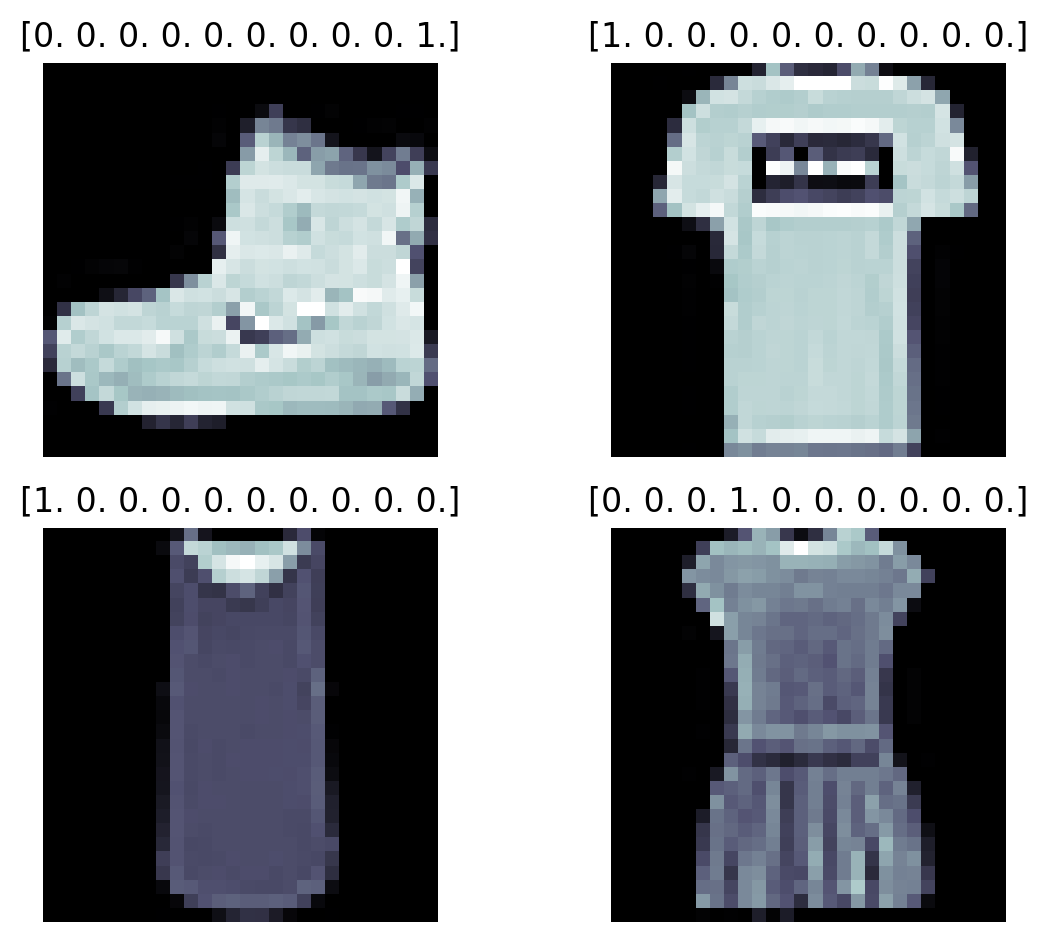

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

In [7]:
key = jax.random.PRNGKey(3141)
key_data, key_train = jax.random.split(key)
key_rot, key_noise = jax.random.split(key_data)

In [8]:
rotation_train = jax.random.uniform(key_rot, shape=len(X_train), minval=0, maxval=2 * jnp.pi)
rotation_train_deg = rotation_train * 180 / jnp.pi

In [9]:
%%time
X_train_new = [rotate(img, deg, reshape=False) for img, deg in tqdm(zip(X_train, rotation_train_deg))]
X_train_new = jnp.stack(X_train_new, axis=0)

60000it [00:29, 2048.55it/s]


CPU times: user 53.9 s, sys: 6.06 s, total: 59.9 s
Wall time: 37.1 s


In [10]:
y_train_new = rotation_train - rotation_train.mean() + jax.random.normal(key_noise, len(X_train_new))

## Train

In [11]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        # x = nn.Dense(20, name="last_layer")(x)
        # x = nn.relu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x.squeeze()

model = CNN()

## Revised version

In [12]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    err = y.squeeze() - yhat.squeeze()
    return err

In [32]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jnp.atleast_1d(eta)

def cov_fn(mean, eps=0.1):
    return jnp.eye(1) * 1.0

In [33]:
n_sims = 1
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, n_sims)
model = CNN()

In [34]:
n_obs = len(X_train_new)

In [35]:
A = jnp.arange(25).reshape(5, 5)
jnp.eye(5) - A

Array([[  1.,  -1.,  -2.,  -3.,  -4.],
       [ -5.,  -5.,  -7.,  -8.,  -9.],
       [-10., -11., -11., -13., -14.],
       [-15., -16., -17., -17., -19.],
       [-20., -21., -22., -23., -23.]], dtype=float32)

In [36]:
r = (-A).at[jnp.diag_indices(5)].add(1)
r

Array([[  1,  -1,  -2,  -3,  -4],
       [ -5,  -5,  -7,  -8,  -9],
       [-10, -11, -11, -13, -14],
       [-15, -16, -17, -17, -19],
       [-20, -21, -22, -23, -23]], dtype=int32)

In [37]:
from jax_tqdm import scan_tqdm

In [197]:
%%time

def run_lrkf(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    params = model.init(key_init, X_train_new[:1])
    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=0.1, low_rank_diag=False)

    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(
        bel_init,
        y_train_new.at[ix_choice].get(),
        X_train_new.at[ix_choice].get(),
        cfn
    )
    return hist_lrkf, bel

hist_lrkf, bel = run_lrkf(key_train, 100)
hist_lrk = jax.tree.map(np.array, hist_lrkf)

Using QR decomposition to initialize low-rank matrix.
(100, 60941)
CPU times: user 8.47 s, sys: 146 ms, total: 8.62 s
Wall time: 29.6 s


In [199]:
df_lrkf = pd.DataFrame(hist_lrkf.T)
df_lrkf.shape

(60000, 1)

<Axes: >

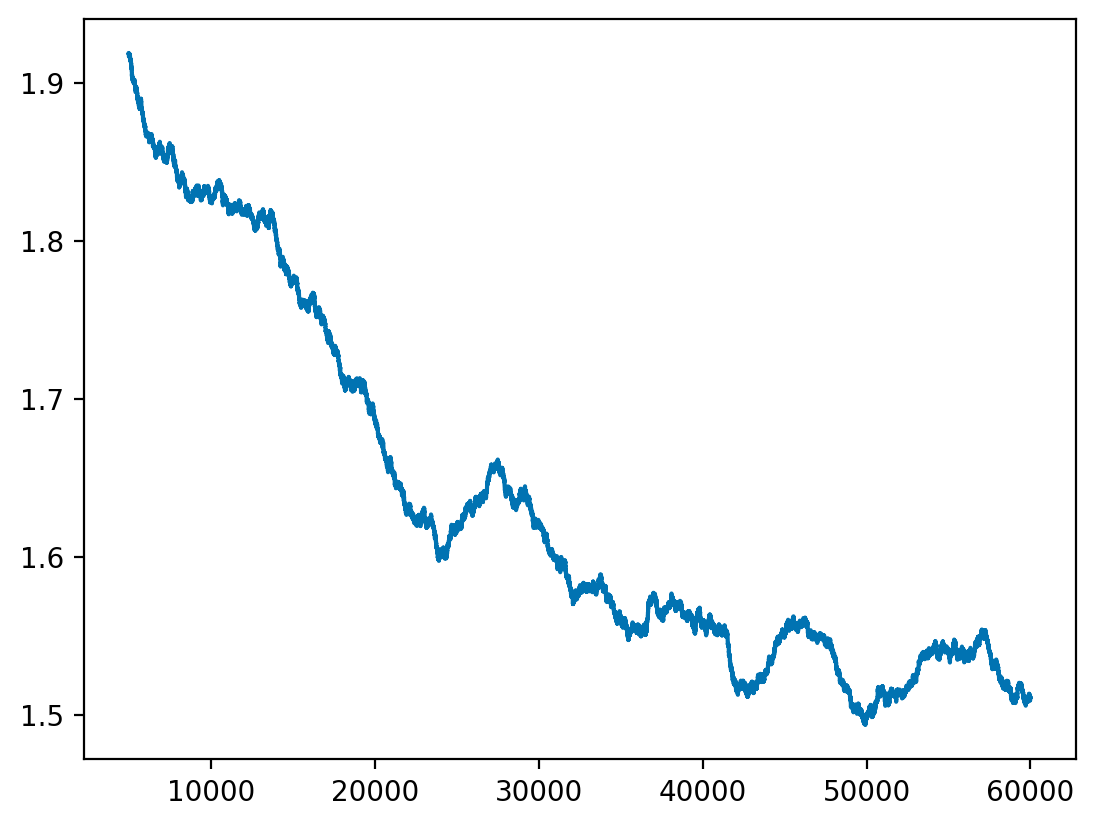

In [200]:
fig, ax = plt.subplots()
np.sqrt(np.power(df_lrkf[0], 2).rolling(5000).mean()).plot(ax=ax)
# np.sqrt(np.power(df_flores[0], 2).rolling(5000).mean()).plot(ax=ax)

# Last-layer Low-rank Kalman filter (HiLoFi)

In [205]:
def cov_fn(mean):
    return jnp.eye(1) * 1.0

In [211]:
%%time
def run_flores(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = flores.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank,
        # dynamics_hidden=1e-3, dynamics_last=1e-3,
        dynamics_hidden=0.01, dynamics_last=0.01,
        rank_last=20
    )
    params = model.init(key, X_train_new[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train_new.at[ix_choice].get(),
        X_train_new.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores, bel_flores

hist_flores, bel = run_flores(key_train, 100)
hist_flores = jax.tree.map(np.array, hist_flores)

Using QR decomposition to initialize low-rank matrix
(20, 85)
CPU times: user 6.7 s, sys: 197 ms, total: 6.9 s
Wall time: 33.8 s


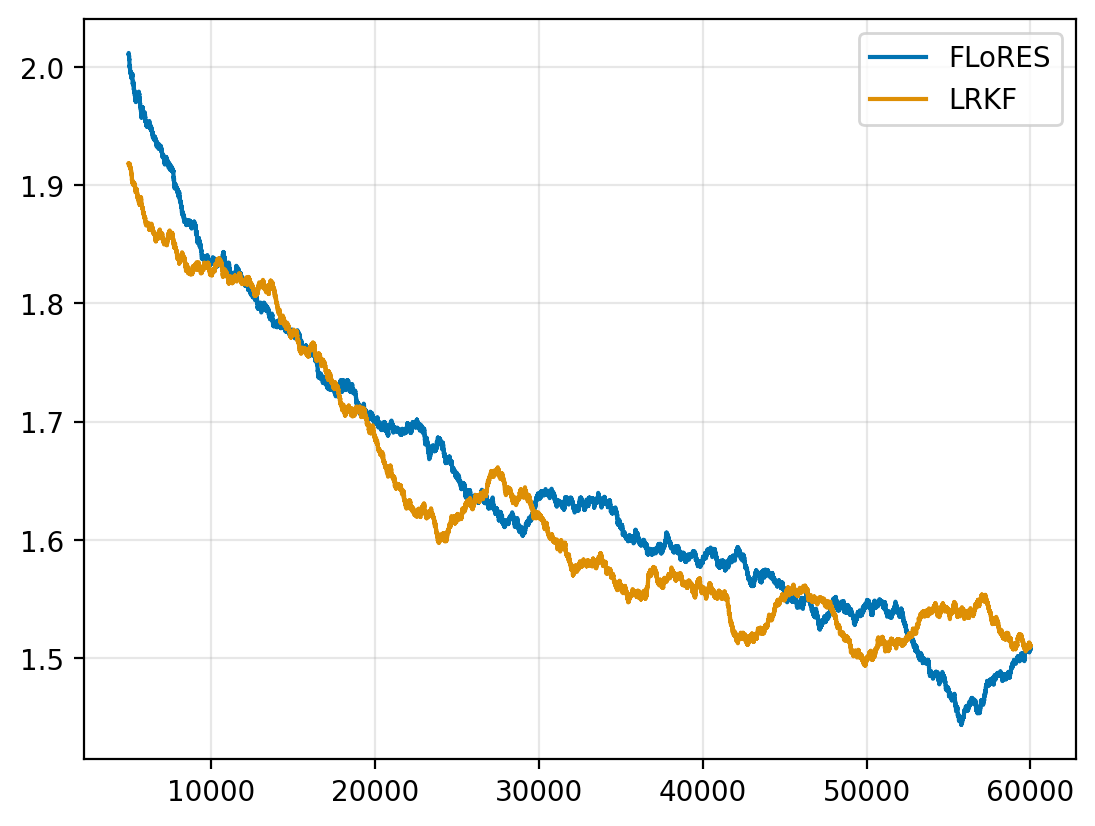

In [212]:
fig, ax = plt.subplots()
window = 5000
np.sqrt(np.power(df_flores[0], 2).rolling(window).mean()).plot(ax=ax, label="FLoRES")
np.sqrt(np.power(df_lrkf[0], 2).rolling(window).mean()).plot(ax=ax, label="LRKF")
# np.sqrt(np.power(df_lofi[0], 2).rolling(window).mean()).plot(ax=ax, label="LoFi")
plt.legend()
plt.grid(alpha=0.3)

## Low-rank (precision) filter (LoFi)

In [193]:
from rebayes_mini.methods import low_rank_filter as lofi

In [194]:
%%time

def run_lofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = lofi.LowRankPrecisionFilter(
        mean_fn, cov_fn, rank=rank, dynamics_covariance=0.0, inflate_diag=False 
    )
    params = model.init(key_init, X_train_new[:100])
    
    bel_init = agent.init_bel(params, cov=0.01)
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lofi = agent.scan(
        bel_init,
        y_train_new.at[ix_choice].get(),
        X_train_new.at[ix_choice].get(),
        cfn
    )
    return hist_lofi

hist_lofi = run_lofi(key)
hist_lofi = jax.tree.map(np.array, hist_lofi)

CPU times: user 10.7 s, sys: 215 ms, total: 10.9 s
Wall time: 33.9 s


In [195]:
df_lofi = pd.DataFrame(hist_lofi.T)
df_lofi.shape
df_lofi.tail()

,0
59995,-2.435447
59996,-1.584588
59997,0.219795
59998,-5.485132
59999,0.064082


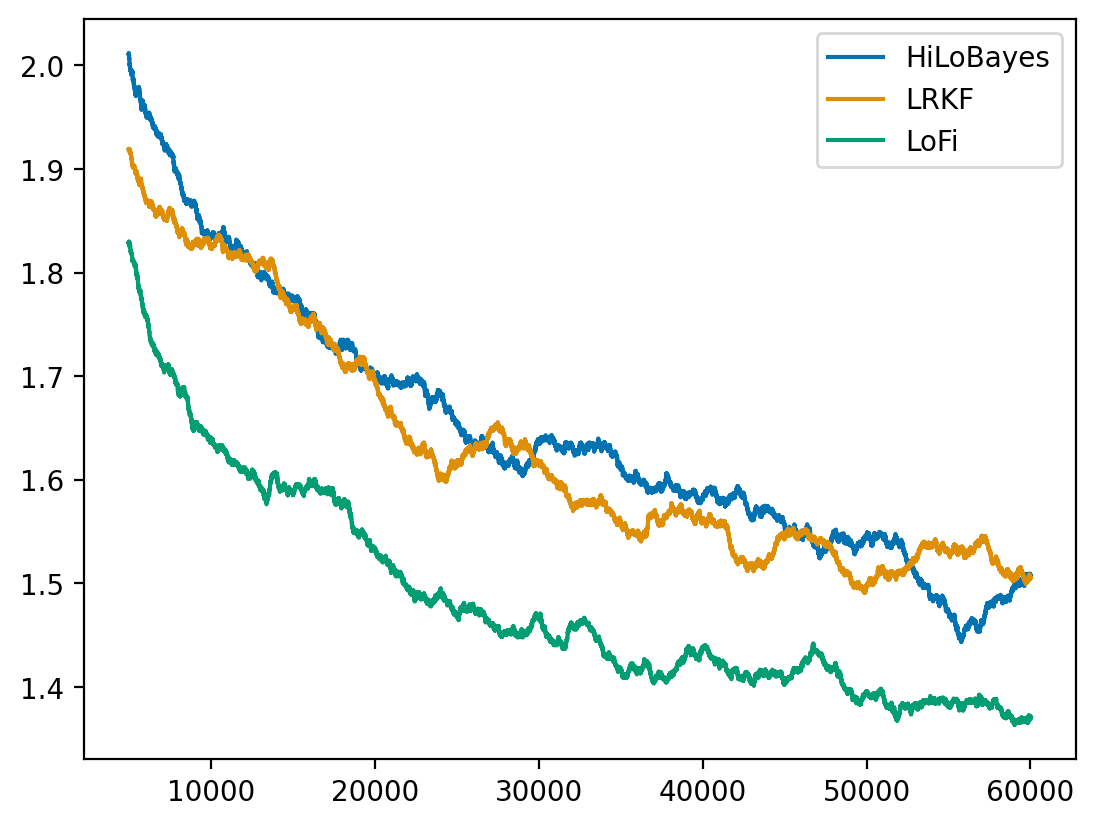

In [196]:
fig, ax = plt.subplots()
window = 5000
np.sqrt(np.power(df_flores[0], 2).rolling(window).mean()).plot(ax=ax, label="HiLoBayes")
np.sqrt(np.power(df_lrkf[0], 2).rolling(window).mean()).plot(ax=ax, label="LRKF")
np.sqrt(np.power(df_lofi[0], 2).rolling(window).mean()).plot(ax=ax, label="LoFi")
plt.legend()

## Time / performance of LoFi / LRKF

In [455]:
key = jax.random.PRNGKey(314)

In [445]:
from tqdm import tqdm

In [446]:
ranks = [1, 5, 10, 20, 30, 40, 50, 100]


result = []
for rank in tqdm(ranks):
    time_init = time()
    hist = run_lrkf(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LRKF",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

    time_init = time()
    hist = run_lofi(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "LoFi",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })


    time_init = time()
    hist = run_flores(key, rank)
    hist = jax.tree.map(np.array, hist)
    time_end = time()
    running_time = time_end - time_init
    result.append({
        "method": "HiLoBayes",
        "running_time": running_time,
        "accuracy": hist[5000:],
        "rank": rank,
    })

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:28<00:00, 71.05s/it]


In [447]:
df_result = pd.DataFrame(result)

df_result["accuracy"] = df_result["accuracy"].apply(lambda x: np.sqrt(np.power(x, 2).mean()))

/tmp/ipykernel_1807033/3698908913.py:3: RuntimeWarning: Mean of empty slice.
  df_result["accuracy"] = df_result["accuracy"].apply(lambda x: np.sqrt(np.power(x, 2).mean()))
/home/gerardoduran/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


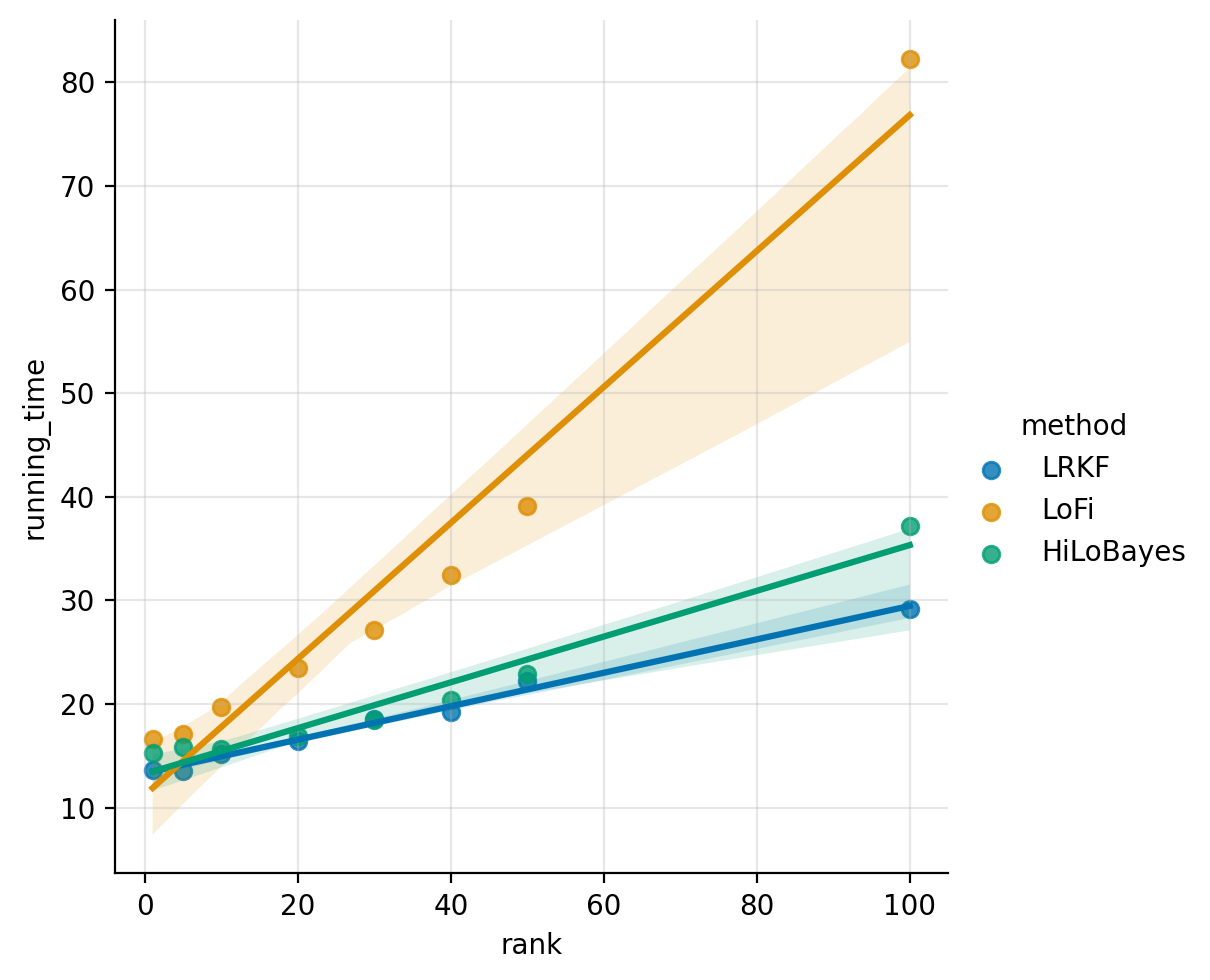

In [448]:
sns.lmplot(x="rank", y="running_time", hue="method", data=df_result)
plt.grid(alpha=0.3)

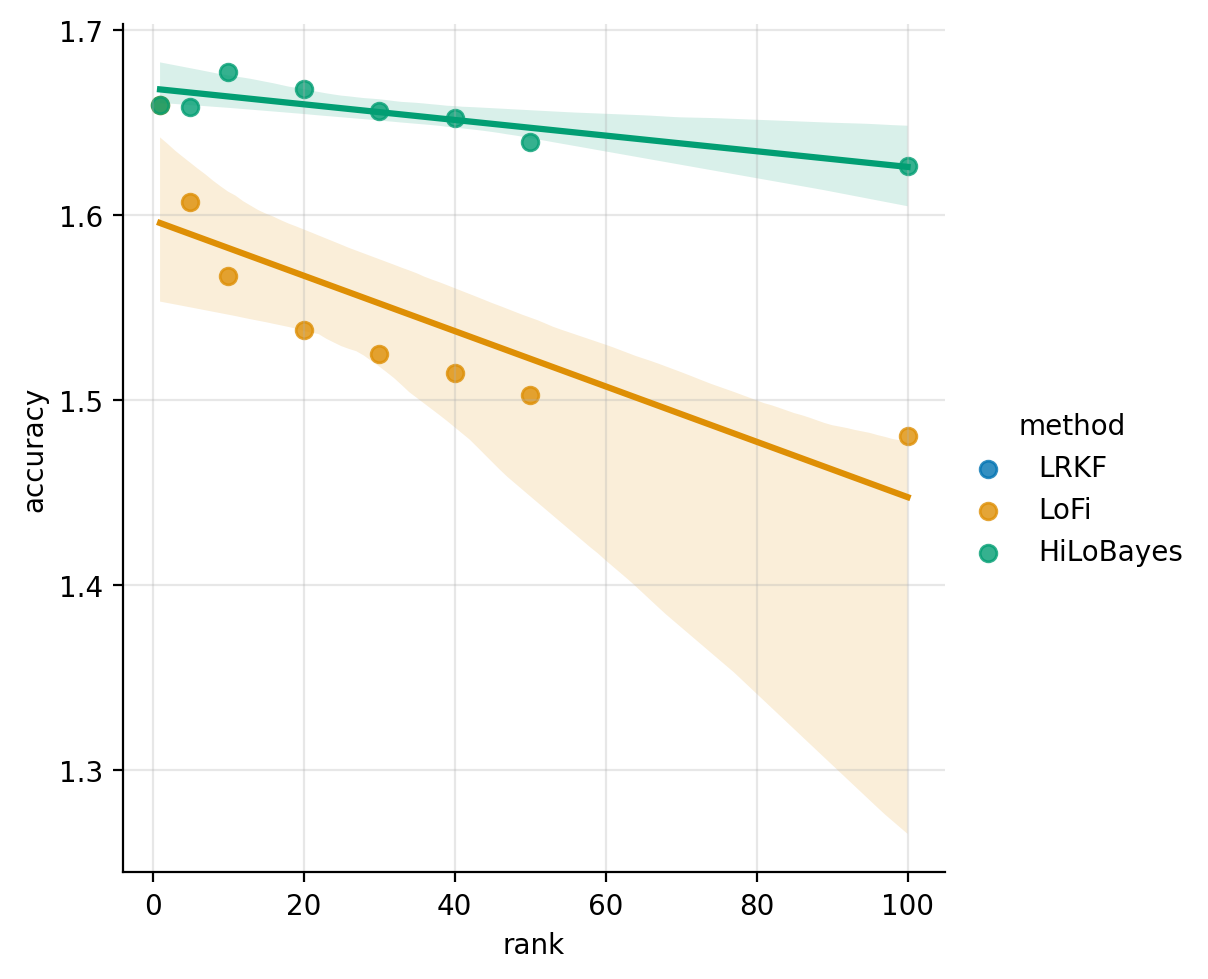

In [450]:
sns.lmplot(x="rank", y="accuracy", hue="method", data=df_result)
plt.grid(alpha=0.3)

## Multiple ranks

With constant full-rank inflation

In [183]:
key = jax.random.PRNGKey(3141)

In [204]:
%%time
ranks = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100]
hist_all = {}
times_all = {}
params = model.init(key, X_train[:100])
for rank in ranks:
    print(rank, end="\r")

    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)


    time_init = time()
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(bel_init, y_train[:20_000], X_train[:20_000], cfn)
    hist_lrkf = np.array(hist_lrkf) * 1.0
    times_all[rank] = time() - time_init
    hist_all[rank] = hist_lrkf

hist_all = pd.DataFrame(hist_all)

CPU times: user 1min 46s, sys: 2.1 s, total: 1min 48s
Wall time: 2min 14s


In [205]:
times_all

{0: 10.78065299987793,
 1: 12.843039512634277,
 2: 12.167240142822266,
 5: 12.281671285629272,
 10: 12.493818759918213,
 20: 12.994854211807251,
 30: 13.339035511016846,
 50: 14.3035249710083,
 70: 15.146733283996582,
 100: 18.53090524673462}

In [206]:
colors = plt.cm.viridis(jnp.linspace(0, 1, len(ranks)))

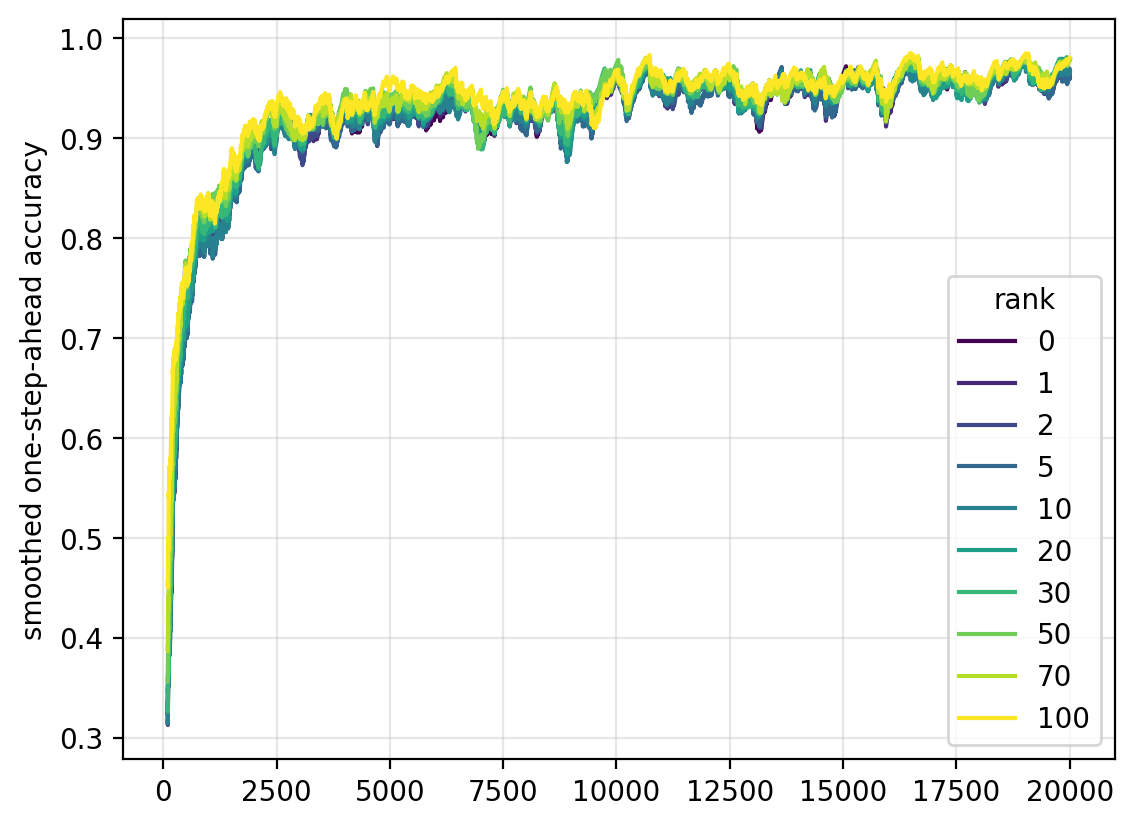

In [207]:
hist_all.ewm(min_periods=100, span=500).mean().plot(color=colors)
plt.ylabel("smoothed one-step-ahead accuracy")
plt.legend(title="rank")
plt.grid(alpha=0.3)